<a href="https://colab.research.google.com/github/VincenzoManzoUnisa/PokemonTypeClassificator/blob/main/pkmClass.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Ensure library versions and some other packages
%%capture
%pip install scipy==1.1.0
%pip uninstall vis
%pip install git+https://github.com/raghakot/keras-vis.git -U
%pip install h5py==2.10.0 --force-reinstall

In [5]:
# Restart the Google Colab Runtime to apply the changes above
import os

def restart_runtime():
  os.kill(os.getpid(), 9)

In [6]:
from keras import backend as K
from tensorflow.python.client import device_lib

import tensorflow as tf
tf.test.is_gpu_available()

%matplotlib inline

import glob
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import imageio as im
from skimage.io import imread
from skimage.transform import resize
from keras import models
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import random
import math

from time import time

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


In [60]:
classes = ['electric','fire','grass','water']


In [61]:
path_to_train_set = 'drive/MyDrive/train_set'
path_to_test_set = 'drive/MyDrive/test_set'
path_to_sample = 'drive/MyDrive/train_set/fire/2.jpg'

Class 0: electric


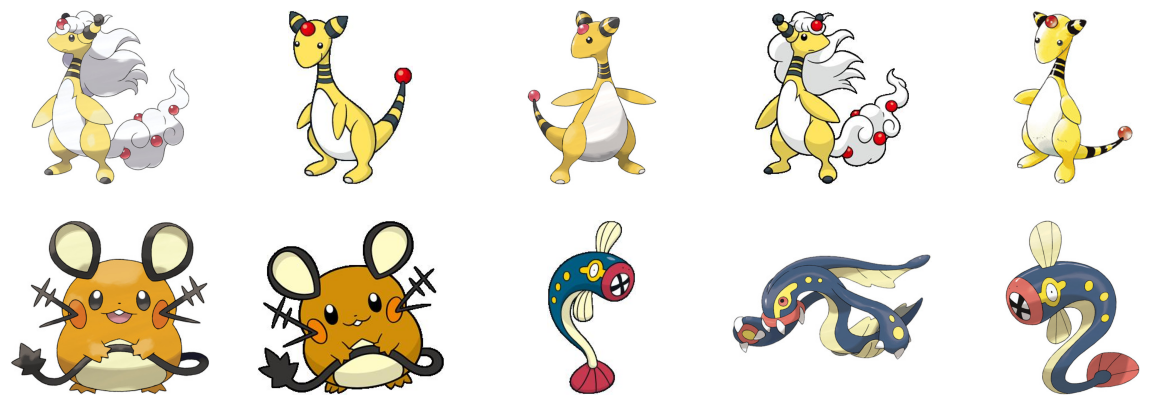


Class 1: fire


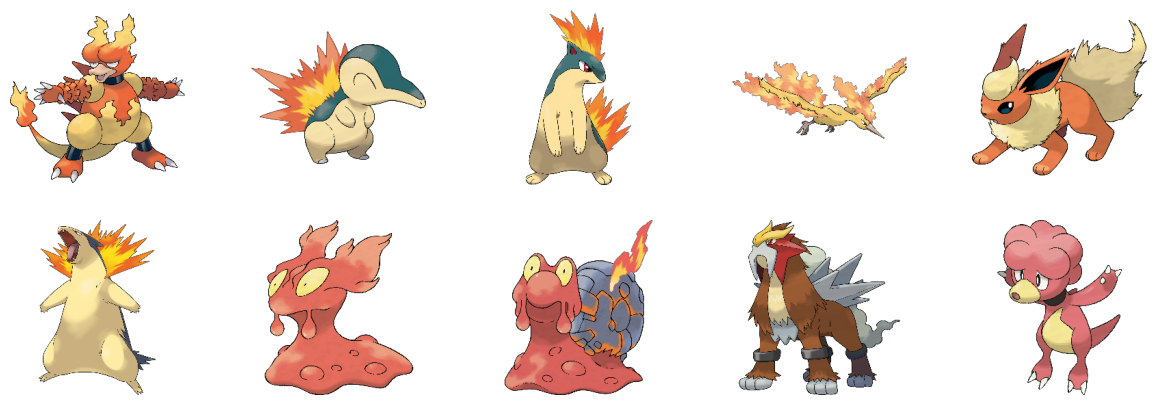


Class 2: grass


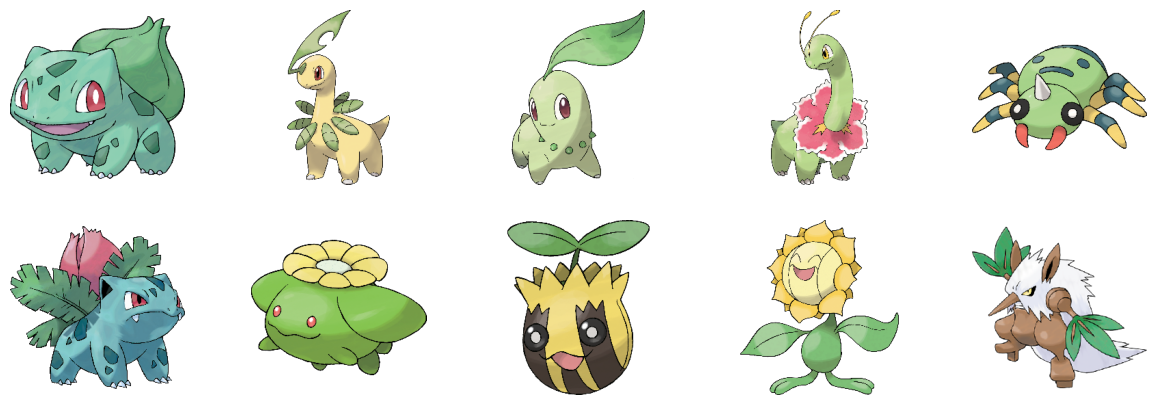


Class 3: water


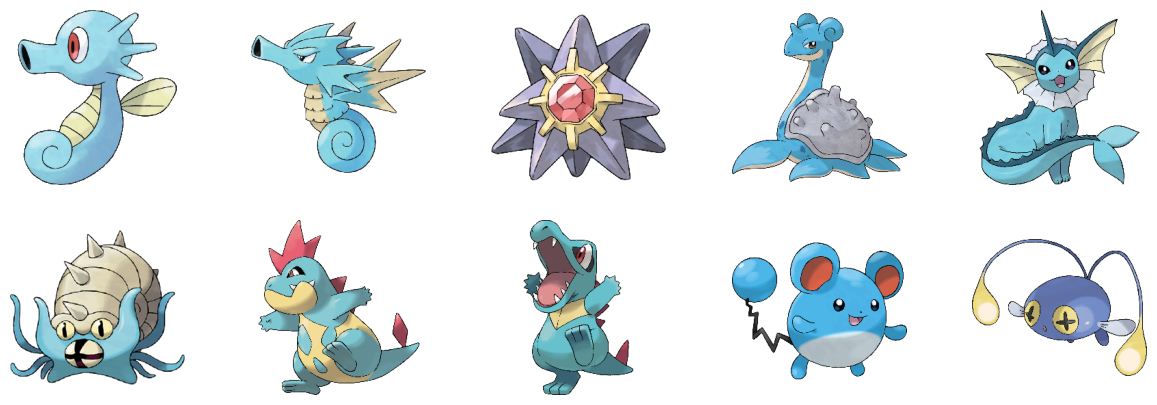

In [62]:
def plot_training_set_images(class_to_plot, path_to_train_set, max_images=10):
    images = []
    image_paths = glob.glob(f'{path_to_train_set}/{class_to_plot}/*.png') + glob.glob(f'{path_to_train_set}/{class_to_plot}/*.jpg')

    # Limita il numero di immagini al massimo di max_images
    image_paths = image_paths[:max_images]

    for img_path in image_paths:
        images.append(mpimg.imread(img_path))

    plt.figure(figsize=(15, 5))
    columns = 5
    rows = 2  # Modifica il numero di righe a 2 per visualizzare solo 10 immagini

    for i, image in enumerate(images):
        plt.subplot(rows, columns, i + 1)
        plt.imshow(image)
        plt.axis('off')

    plt.show()

for i in range(len(classes)):
    print(f"Class {i}: {classes[i]}")
    plot_training_set_images(classes[i], path_to_train_set, max_images=10)
    print("")


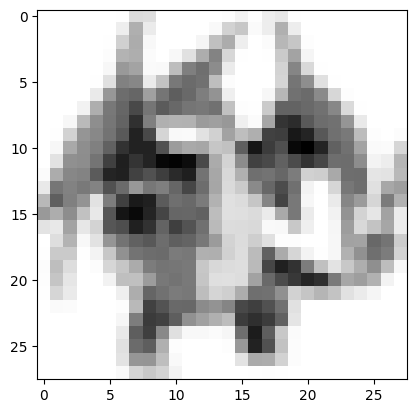

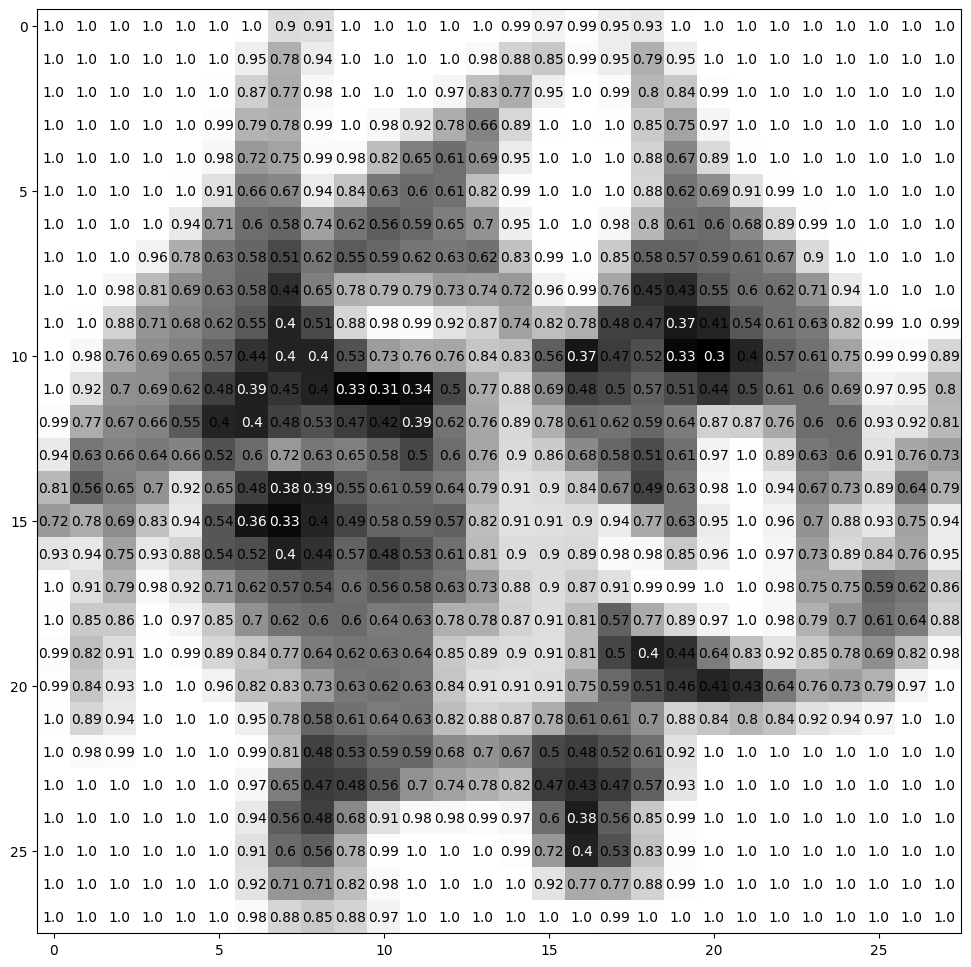

In [63]:
def plot_image_with_pixel_values(img, ax):
  '''
    Questa funzione visualizza un'immagine e i valori in scala di grigi per ogni pixel
  '''
  ax.imshow(img, cmap='gray')
  width, height = img.shape
  thresh = img.max() / 2.5
  for x in range(width):
      for y in range(height):
          ax.annotate(str(round(img[ x ][ y ], 2)), xy=(y, x),
                  horizontalalignment='center',
                  verticalalignment='center',
                  color='white' if img[ x ][ y ] < thresh else 'black')

def plot_image(path_to_image):
    '''
    Questa funzione visualizza un'immagine ridimensionata alle dimensioni utilizzate per il modello
    e visualizza anche la scala di grigi dei pixel in un'immagine separata
    '''
    # Carica un'immagine a colori convertendola in scala di grigi
    image = imread(path_to_image, as_gray=True)

    # Ridimensiona l'immagine a 28x28 pixel
    image = resize(image, (28, 28), mode='reflect')

    # Mostra l'immagine ridimensionata in scala di grigi
    plt.imshow(image, cmap='gray')

    # Crea una nuova figura per mostrare i valori dei pixel
    fig = plt.figure(figsize=(12, 12))
    ax = fig.add_subplot(111)

    # Chiama la funzione plot_image_with_pixel_values per mostrare i valori dei pixel sovrapposti
    plot_image_with_pixel_values(image, ax)


plot_image(path_to_sample)


In [64]:
# Initialising the CNN
classifier = Sequential()

In [65]:
# Step 1 - Convolution


classifier.add(Conv2D(32, (3, 3), padding='valid', input_shape=(28, 28, 3), activation='relu'))
classifier.add(Conv2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5))

# # Adding a second convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='valid', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5))

# # OPTIONAL: Adding a third convolutional layer
classifier.add(Conv2D(64, (3, 3), padding='same', activation = 'relu'))
classifier.add(Conv2D(64, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Dropout(0.5)) # before used 0.25


# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(units = 128, activation = 'relu'))
classifier.add(Dense(units = 512, activation = 'relu')) # OPTIONAL
classifier.add(Dropout(0.5))
classifier.add(Dense(units = len(classes), activation = 'softmax', name='preds'))


In [66]:
classifier.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 26, 26, 32)        896       
                                                                 
 conv2d_7 (Conv2D)           (None, 24, 24, 32)        9248      
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 12, 12, 32)        0         
 g2D)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 12, 12, 32)        0         
                                                                 
 conv2d_8 (Conv2D)           (None, 10, 10, 64)        18496     
                                                                 
 conv2d_9 (Conv2D)           (None, 8, 8, 64)          36928     
                                                      

In [67]:
# Compiling the CNN
classifier.compile(optimizer = 'rmsprop',
                   loss = 'categorical_crossentropy',
                   metrics = ['accuracy'])

In [68]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(path_to_train_set, target_size = (28, 28), batch_size = 16, class_mode = 'categorical')

test_set = test_datagen.flow_from_directory(path_to_test_set, target_size = (28, 28), batch_size = 16, class_mode = 'categorical')


Found 311 images belonging to 4 classes.
Found 89 images belonging to 4 classes.


In [69]:
from keras.callbacks import EarlyStopping
checkpointer = ModelCheckpoint(filepath="best_weights.hdf5",
                               monitor = 'val_accuracy',
                               verbose=1,
                               save_best_only=True
                               )


earlystopping = EarlyStopping(monitor='val_accuracy',
                               patience=10,  # Numero di epoche senza miglioramenti prima di interrompere
                               restore_best_weights=True)


In [70]:
history = classifier.fit(training_set,
                         steps_per_epoch = 10,
                         epochs = 100,
                         callbacks=[checkpointer],
                         verbose = 1,
                         validation_data = test_set)

Epoch 1/100
10/10 [==============================] - ETA: 0s - loss: 1.4018 - accuracy: 0.2318
Epoch 1: val_accuracy improved from -inf to 0.30337, saving model to best_weights.hdf5
10/10 [==============================] - 20s 2s/step - loss: 1.4018 - accuracy: 0.2318 - val_loss: 1.3869 - val_accuracy: 0.3034


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/100
10/10 [==============================] - ETA: 0s - loss: 1.3868 - accuracy: 0.2252
Epoch 2: val_accuracy did not improve from 0.30337
10/10 [==============================] - 4s 396ms/step - loss: 1.3868 - accuracy: 0.2252 - val_loss: 1.3894 - val_accuracy: 0.2472
Epoch 3/100
10/10 [==============================] - ETA: 0s - loss: 1.3836 - accuracy: 0.2937
Epoch 3: val_accuracy improved from 0.30337 to 0.31461, saving model to best_weights.hdf5
10/10 [==============================] - 4s 378ms/step - loss: 1.3836 - accuracy: 0.2937 - val_loss: 1.3760 - val_accuracy: 0.3146
Epoch 4/100
10/10 [==============================] - ETA: 0s - loss: 1.4009 - accuracy: 0.3000
Epoch 4: val_accuracy did not improve from 0.31461
10/10 [==============================] - 3s 307ms/step - loss: 1.4009 - accuracy: 0.3000 - val_loss: 1.3910 - val_accuracy: 0.2247
Epoch 5/100
10/10 [==============================] - ETA: 0s - loss: 1.3473 - accuracy: 0.4313
Epoch 5: val_accuracy improved from

In [71]:
classifier.load_weights('best_weights.hdf5')

In [72]:
classifier.save('shapes_cnn.h5')


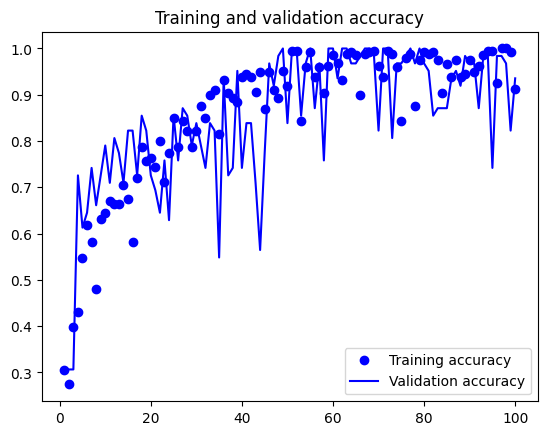

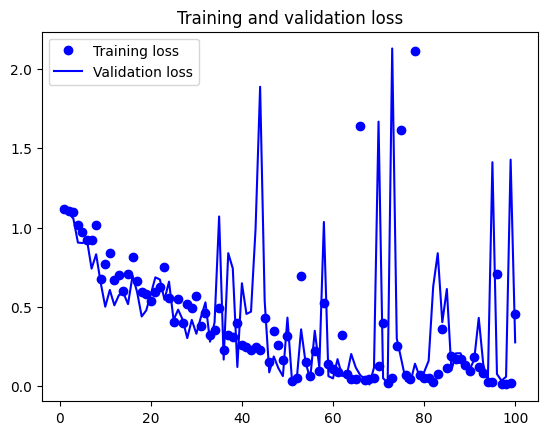

In [ ]:
def plot_model_learning(history):
  '''
  Visualizzazione del modello per ogni epoch
  '''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(1, len(acc) + 1)

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

plot_model_learning(history)


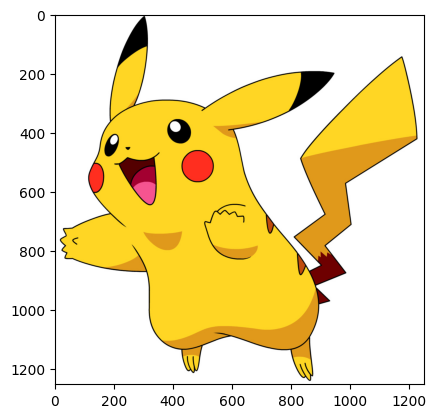

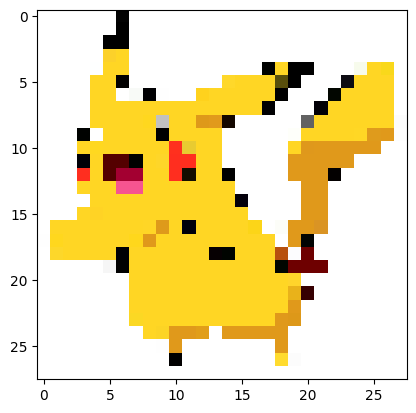

1/1 [==============================] - 0s 36ms/step
Probability for class electric: 0.9007390737533569
Probability for class fire: 0.04575427621603012
Probability for class grass: 0.04933575913310051
Probability for class water: 0.004170984961092472
Tipo del pokemon predetto dal modello: electric
Tipo reale del pokemon: electric
Il modello ha indovinato!




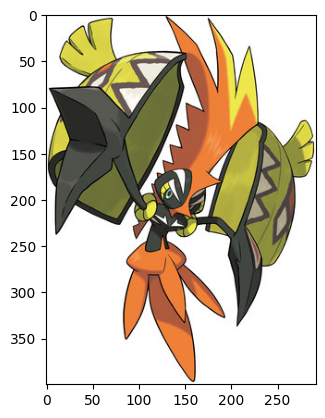

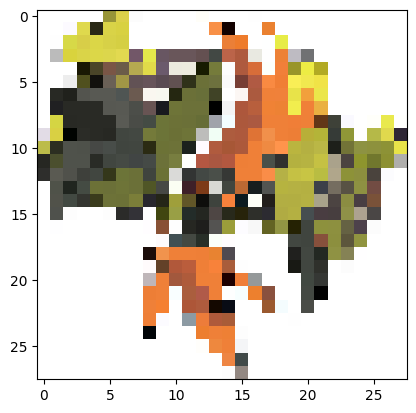

1/1 [==============================] - 0s 31ms/step
Probability for class electric: 0.2183818221092224
Probability for class fire: 0.7324244379997253
Probability for class grass: 0.048133280128240585
Probability for class water: 0.0010605243733152747
Tipo del pokemon predetto dal modello: fire
Tipo reale del pokemon: electric




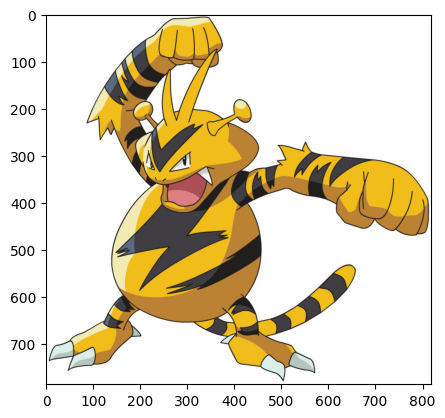

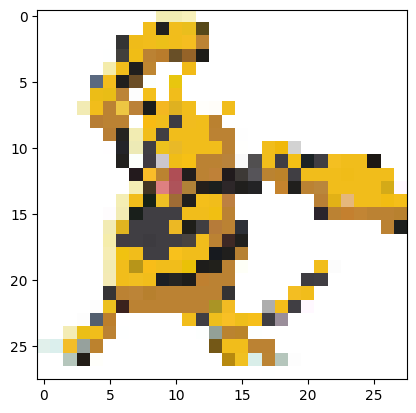

1/1 [==============================] - 0s 32ms/step
Probability for class electric: 0.7955303192138672
Probability for class fire: 0.09136579185724258
Probability for class grass: 0.09823356568813324
Probability for class water: 0.01487038005143404
Tipo del pokemon predetto dal modello: electric
Tipo reale del pokemon: electric
Il modello ha indovinato!




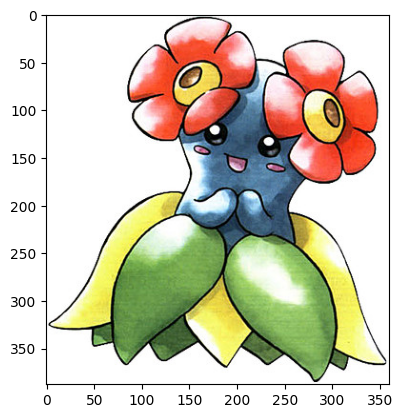

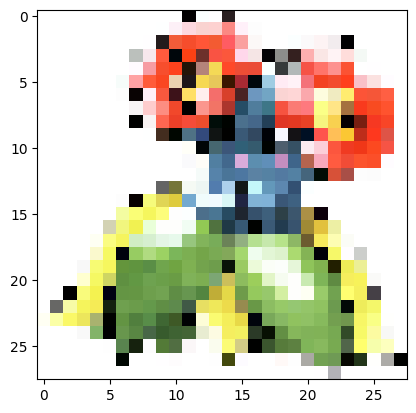

1/1 [==============================] - 0s 48ms/step
Probability for class electric: 0.026750018820166588
Probability for class fire: 0.0011647687060758471
Probability for class grass: 0.9673439264297485
Probability for class water: 0.004741361830383539
Tipo del pokemon predetto dal modello: grass
Tipo reale del pokemon: grass
Il modello ha indovinato!




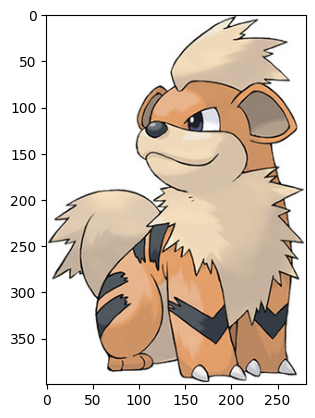

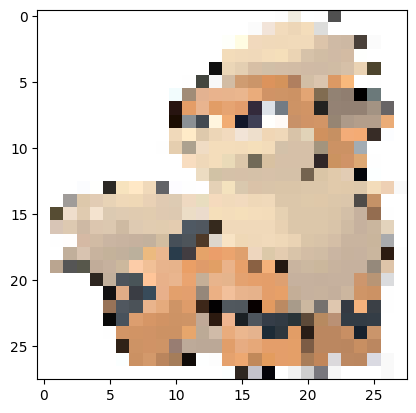

1/1 [==============================] - 0s 32ms/step
Probability for class electric: 0.39608022570610046
Probability for class fire: 0.5070899724960327
Probability for class grass: 0.0907321497797966
Probability for class water: 0.006097641307860613
Tipo del pokemon predetto dal modello: fire
Tipo reale del pokemon: fire
Il modello ha indovinato!




In [75]:
def predict_new_images(classifier, classes, path_to_test_set, num_predictions=5):
    '''
    Questa funzione prende 5 immagini casuali dalla path di test e prevede a quale classe appartengono
    '''

    for _ in range(num_predictions):
        # Randomly choose from one of our classes
        random_class = random.choice(classes)

        # Select a random image from the class selected above
        random_test_image = random.choice(os.listdir(f'{path_to_test_set}/{random_class}/'))

        # Build the path for the random image
        img_path = f'{path_to_test_set}/{random_class}/{random_test_image}'

        # Load the image
        normalImage = image.load_img(img_path)

        img = image.load_img(img_path, target_size=(28, 28))
        img_tensor = image.img_to_array(img)
        img_tensor = np.expand_dims(img_tensor, axis=0)
        img_tensor /= 255.

        # Plot the image
        plt.imshow(normalImage)
        plt.show()

        plt.imshow(img_tensor[0])
        plt.show()

        # Predict the class probabilities of the image
        predictions = classifier.predict(img_tensor)[0]

        # Print the predicted probabilities for each class
        for class_name, probability in zip(classes, predictions):
            print(f"Probability for class {class_name}: {probability}")

        # Extract the predicted class
        predicted_class_index = np.argmax(predictions)
        predicted_class = classes[predicted_class_index]

        print(f"Tipo del pokemon predetto dal modello: {predicted_class}\nTipo reale del pokemon: {random_class}")
        if predicted_class == random_class:
            print("Il modello ha indovinato!")

        print("\n" + "=" * 50 + "\n")  # Separatore tra le previsioni successive


# Chiamata alla funzione con la nuova classe
predict_new_images(classifier, classes, path_to_test_set, num_predictions=5)
